In [0]:
#start tika server. The Tika Server is the Parser
#java -jar "path\to\tika-server-1.22.jar"

# 1. Reading Texts from Documents and Data Cleaning

In [0]:
#import necessary modules
import tika
tika.initVM()
from tika import parser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import dask.dataframe as dd

In [0]:
#define a parameter for tika parsers. This declaration solves the status 422 server error
headers = {'X-Tika-PDFextractInlineImages': 'true', "X-Tika-OCRLanguage": "eng"} 

In [0]:
#Save dataframe as csv file
doc_type_df = pd.read_csv(r"parsed-doc-type-training-data-4.csv", encoding = "ISO-8859-1")

In [0]:
#parse text from scanned files
def ocr_pdf(file):
    images = convert_from_path(file)
    ocr_list = [pytesseract.image_to_string(x) for x in images]
    ocr = ''
    return ocr.join(ocr_list)

In [0]:
#Run Tika Parser on Texts
def return_parsed(paths):
    try:
        return parser.from_file(paths, headers=headers)
    except:
        return 'path error'

In [0]:
#Extract Text Content of Parsed Documents. If Documents not parsed, OCR the document
def return_texts(parsed, paths):
    if 'content' in parsed and parsed['content'] is not None:
        return parsed['content'] #extract 'content' from parsed texts
    else:
        try:
            return ocr_pdf(paths) #if no 'content' from tika parser, try OCRing the document
        except:
            return "no content"   

In [0]:
#Function to remove whitespaces from 
def remove_whitespace(text):
    return text.strip()

In [0]:
#Apply function to parse documents
doc_type_df = dd.from_pandas(doc_type_df, npartitions=5)
parsed = doc_type_df.apply(lambda row: return_parsed(row['Path']), axis = 1).compute()
doc_type_df['Parsed'] = parsed 

In [0]:
#Apply function to retrieve text or OCR documents
texts =  doc_type_df.apply(lambda row: return_texts(row['Parsed'], row['Path']), axis = 1).compute()
doc_type_df['Texts'] = texts
doc_type_df = doc_type_df.compute()

In [0]:
#Apply function to remove whitespace from Document_Type field
Document_Type = doc_type_df.apply(lambda row: remove_whitespace(row['Document_Type']), axis = 1)
doc_type_df['Document_Type'] = Document_Type

In [0]:
#Drop rows with no text content
no_content = doc_type_df[doc_type_df['Texts'] == 'no content'].index
doc_type_df.drop(no_content, inplace=True)
isnan = doc_type_df[doc_type_df['Document_Type'].isna() == True].index
doc_type_df.drop(isnan, inplace=True)

In [0]:
doc_type_df.shape

(1033, 5)

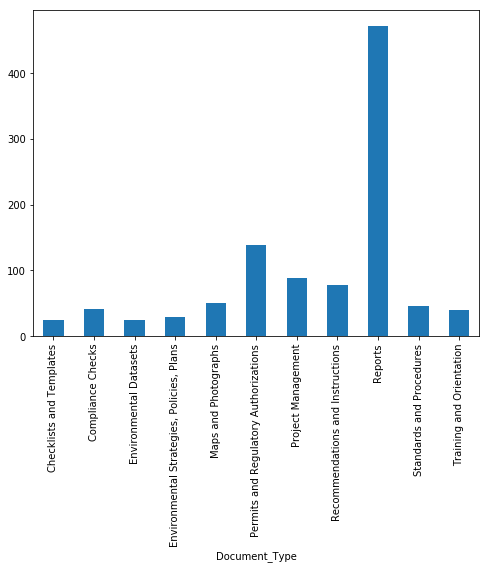

In [0]:
"""Plot of Document Samples Grouped by Document Type"""
fig = plt.figure(figsize=(8,6))
doc_type_df.groupby('Document_Type').Texts.count().plot.bar(ylim=0)
plt.show()



# 2. Model Training and Testing



In [0]:
#Create Vectorizer Object
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [0]:
#create the ML labels by factorizing
y, mappings =doc_type_df.Document_Type.factorize()

In [0]:
#test X value
X = doc_type_df.Texts

In [0]:
#Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [0]:
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [0]:
#train and test classifier
clf = MLPClassifier()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.8357487922705314


In [0]:
# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = mappings))

[[92  0  0  1  0  0  0  0  1  0  0]
 [ 2  4  0  0  0  0  0  0  0  0  0]
 [ 1  0 27  0  0  0  0  0  0  0  0]
 [ 3  0  1 11  0  0  1  1  1  0  0]
 [ 2  1  1  0  4  0  1  0  0  0  0]
 [ 1  0  1  0  1  5  0  0  0  0  0]
 [ 6  0  0  1  1  0  6  0  1  1  0]
 [ 0  0  0  1  1  0  0  3  0  0  0]
 [ 1  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0]
 [ 1  0  0  0  0  0  0  0  0  0  9]]
                                           precision    recall  f1-score   support

                                  Reports       0.84      0.98      0.91        94
Environmental Strategies, Policies, Plans       0.80      0.67      0.73         6
    Permits and Regulatory Authorizations       0.90      0.96      0.93        28
                       Project Management       0.79      0.61      0.69        18
                 Standards and Procedures       0.57      0.44      0.50         9
                        Compliance Checks       1.00      0.62      0.77         8
         Recommendati

In [0]:
#Re-define X value using all available data
X = tfidf.fit_transform(doc_type_df.Texts).toarray()

In [0]:
#Re-train classifier using all available data
clf = MLPClassifier()
clf.fit(X, y)

In [0]:
#save trained model
model_save = r"\\esri-shelf\ESRIENVIROHUB\TaggerBot\final-doc-type-model.sav"
pickle.dump(clf, open(model_save, 'wb'))

In [0]:
#Open saved trained model and test
loaded_model = pickle.load(open(model_save, 'rb'))
accuracy = loaded_model.score(X_test, y_test)
print(accuracy)



3. Hyper-parameter Optimization



In [0]:
"""HyperParameter Tuning for kNN. Choosing the best K Value"""
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 15)
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [0]:
"""Hyperparameter tuning for Logistic Regression"""

# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 19306.977288832535}
Best score is 0.7159841479524438


In [0]:
"""Hyperparameter tuning for SVC"""

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    print("Tuned Logistic Regression Parameters: {}".format(grid_search.best_params_)) 
    print("Best score is {}".format(grid_search.best_score_))

svc_param_selection(X, y, 3)

{'C': 10, 'gamma': 0.1}

In [0]:
"""Hyperparameter tuning for Decision Tree Classifier"""
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": range(1, 9),
              "max_features": range(1, 9),
              "min_samples_leaf": range(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 3}
Best score is 0.5165125495376486


In [0]:
"""Hyperparameter tuning for SVC"""

def mlp_param_selection(X, y, nfolds):
    param_grid = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'learning_rate': ['constant','adaptive']}
    grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    print("MLP Classifier Parameters: {}".format(grid_search.best_params_)) 
    print("Best score is {}".format(grid_search.best_score_))

mlp_param_selection(X, y, 2)